In [962]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as pl
from sklearn import linear_model
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import tree, ensemble, metrics, cross_validation, externals
%matplotlib inline

In [963]:
data = pd.read_csv("output2.csv")

In [964]:
data = data.drop('Unnamed: 0', 1)
data = data.drop('cost_per_impression', 1)

In [965]:
data = data.dropna()

In [966]:
data.columns

Index([u'campaign_id', u'reach', u'cpa_min', u'cpa_max', u'cpa_median',
       u'cpc_min', u'cpc_max', u'cpc_median', u'cpm_min', u'cpm_max',
       u'cpm_median', u'clicks', u'spent', u'impressions', u'conversions',
       u'objective', u'date', u'cost_per_click', u'cost_per_conversion',
       u'Objective_EVENT_RESPONSES', u'Objective_LEAD_GENERATION',
       u'Objective_LOCAL_AWARENESS', u'Objective_MOBILE_APP_ENGAGEMENT',
       u'Objective_MOBILE_APP_INSTALLS', u'Objective_NONE',
       u'Objective_PAGE_LIKES', u'Objective_POST_ENGAGEMENT',
       u'Objective_VIDEO_VIEWS', u'Objective_WEBSITE_CLICKS',
       u'Objective_WEBSITE_CONVERSIONS', u'campaign_group_id', u'bidStrategy',
       u'maxBid', u'Bid_Type_CONVERSION_OPTIMIZE', u'Bid_Type_OPTIMIZE',
       u'Bid_Type_ROTATE', u'Bid_Type_ROTATE_INDEFINITELY',
       u'Bid_Type_automated', u'Bid_Type_cpc', u'Bid_Type_ocpm'],
      dtype='object')

In [967]:
def drop_cost_per_conversion_outliers(df):
    print 'Dropping outliers'
    print '- n (before) =', len(df)

    Q1 = df.cost_per_conversion.quantile(.25)
    Q2 = df.cost_per_conversion.quantile(.5)
    Q3 = df.cost_per_conversion.quantile(.75)
    IQR = Q3 - Q1

    print '- Q1         =', Q1, '($M)'
    print '- Q2/Median  =', Q2, '($M)'
    print '- Q3         =', Q3, '($M)'

    df.drop(df[(df.cost_per_conversion < Q1 - 1.5 * IQR) | (df.cost_per_conversion > Q3 + 1.5 * IQR)].index, inplace = True)

    print '- n (after)  =', len(df)

In [968]:
def drop_reach_outliers(df):
    print 'Dropping outliers'
    print '- n (before) =', len(df)

    Q1 = df.reach.quantile(.25)
    Q2 = df.reach.quantile(.5)
    Q3 = df.reach.quantile(.75)
    IQR = Q3 - Q1

    print '- Q1         =', Q1, '($M)'
    print '- Q2/Median  =', Q2, '($M)'
    print '- Q3         =', Q3, '($M)'

    df.drop(df[(df.reach < Q1 - 1.5 * IQR) | (df.reach > Q3 + 1.5 * IQR)].index, inplace = True)

    print '- n (after)  =', len(df)

In [969]:
drop_cost_per_conversion_outliers(data)

Dropping outliers
- n (before) = 709
- Q1         = 0.177419354839 ($M)
- Q2/Median  = 0.520602836879 ($M)
- Q3         = 2.47513513514 ($M)
- n (after)  = 568


In [970]:
drop_reach_outliers(data)

Dropping outliers
- n (before) = 568
- Q1         = 50750.0 ($M)
- Q2/Median  = 354500.0 ($M)
- Q3         = 1660000.0 ($M)
- n (after)  = 495


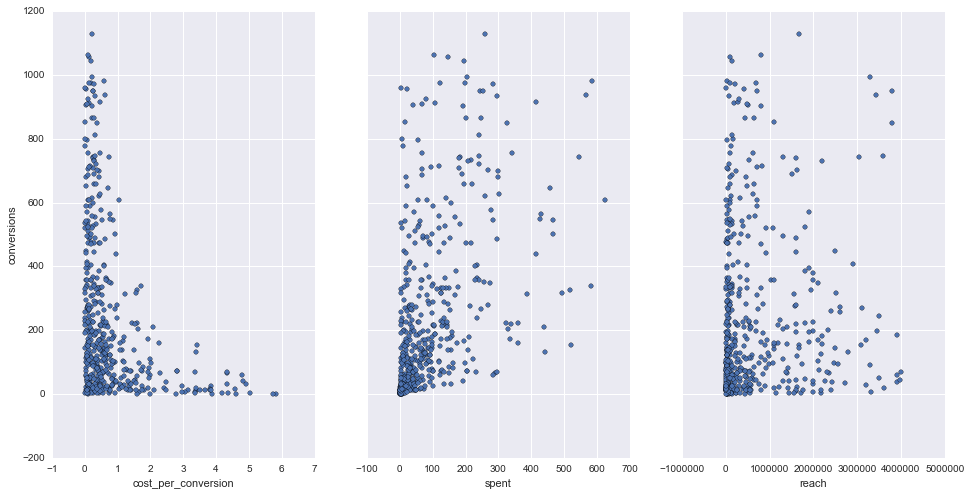

In [971]:
# visualize the relationship between the features and the response using scatterplots
fig, axs = plt.subplots(1, 3, sharey=True)
data.plot(kind='scatter', x='cost_per_conversion', y='conversions', ax=axs[0], figsize=(16, 8))
data.plot(kind='scatter', x='spent', y='conversions', ax=axs[1])
data.plot(kind='scatter', x='reach', y='conversions', ax=axs[2])

In [972]:
len(data)

495

In [973]:
data['maxBid_cpc'] = data.maxBid * data.Bid_Type_cpc

In [974]:
data['maxBid_ocpm'] = data.maxBid * data.Bid_Type_ocpm

In [975]:
training_df = data.sample(frac = .6, random_state = 1)
test_df = data.drop(training_df.index)

In [976]:
training_df.reset_index(inplace = True)
test_df.reset_index(inplace = True)

In [977]:
training_df = training_df.dropna()
test_df = test_df.dropna()

**features**

- spent
- cost_per_click
- Objective_EVENT_RESPONSES,Objective_LEAD_GENERATION .....  
- maxBid_cpc
- maxBid_ocpm
- Bid_Type_automated
- Bid_Type_cpc
- Bid_Type_ocpm
- cpa_min 
- cpa_max  
- cpa_median
- cpc_min 
- cpc_max
- cpc_median
- cpm_min
- cpm_max
- cpm_median
- objective
- date
- Bid_Type_CONVERSION_OPTIMIZE
- Bid_Type_OPTIMIZE
- Bid_Type_ROTATE
- Bid_Type_ROTATE_INDEFINITELY

** response **

Conversions : Number of conversions for a particular campaign 

In [978]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 296
Data columns (total 43 columns):
index                              297 non-null int64
campaign_id                        297 non-null int64
reach                              297 non-null int64
cpa_min                            297 non-null float64
cpa_max                            297 non-null float64
cpa_median                         297 non-null float64
cpc_min                            297 non-null float64
cpc_max                            297 non-null float64
cpc_median                         297 non-null float64
cpm_min                            297 non-null float64
cpm_max                            297 non-null float64
cpm_median                         297 non-null float64
clicks                             297 non-null int64
spent                              297 non-null float64
impressions                        297 non-null int64
conversions                        297 non-null int64
objective  

In [979]:
training_df[training_df.Bid_Type_ocpm == 1].maxBid

54     0
75     0
80     0
93     0
96     0
128    0
143    0
146    0
149    0
154    0
166    0
167    0
173    0
200    0
215    0
221    0
225    0
262    0
264    0
294    0
Name: maxBid, dtype: float64

## Linear Regression Model 

In [980]:
model = smf.ols(formula = 'cost_per_conversion ~ spent + Objective_EVENT_RESPONSES + Objective_LEAD_GENERATION + Objective_LOCAL_AWARENESS + Objective_MOBILE_APP_ENGAGEMENT + Objective_MOBILE_APP_INSTALLS + Objective_PAGE_LIKES + Objective_POST_ENGAGEMENT + Objective_VIDEO_VIEWS+ Objective_WEBSITE_CONVERSIONS + Bid_Type_automated + Bid_Type_cpc + maxBid_cpc + cpa_median + cpc_median + cpm_median', data = training_df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     cost_per_conversion   R-squared:                       0.376
Model:                             OLS   Adj. R-squared:                  0.352
Method:                  Least Squares   F-statistic:                     15.60
Date:                 Thu, 21 Apr 2016   Prob (F-statistic):           9.02e-24
Time:                         23:46:50   Log-Likelihood:                -374.02
No. Observations:                  297   AIC:                             772.0
Df Residuals:                      285   BIC:                             816.4
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Intercept                           0.2799      0.173      1.616      0.107        -0.061     0.621
spent                               0.0015      0.001      2.876      0.004         0.000     0.003
Objective_EVENT_RESPONSES        4.636e-14   5.76e-14      0.804      0.422     -6.71e-14   1.6e-13
Objective_LEAD_GENERATION        1.203e-14   1.35e-14      0.894      0.372     -1.44e-14  3.85e-14
Objective_LOCAL_AWARENESS       -5.571e-16   5.81e-16     -0.958      0.339      -1.7e-15  5.87e-16
Objective_MOBILE_APP_ENGAGEMENT  4.512e-15    5.2e-15      0.868      0.386     -5.72e-15  1.47e-14
Objective_MOBILE_APP_INSTALLS       2.4574      0.341      7.198      0.000         1.785     3.129
Objective_PAGE_LIKES                0.5305      0.224      2.364      0.019         0.089     0.972
Objective_POST_ENGAGEMENT          -0.2198      0.119     -1.854      0.065        -0.453     0.014
Objective_VIDEO_VIEWS            1.767e-16   5.14e-16      0.344      0.731     -8.35e-16  1.19e-15
Objective_WEBSITE_CONVERSIONS       1.6398      0.181      9.070      0.000         1.284     1.996
Bid_Type_automated                  0.1299      0.167      0.780      0.436        -0.198     0.458
Bid_Type_cpc                        0.5021      0.321      1.565      0.119        -0.129     1.134
maxBid_cpc                        -10.6659     13.106     -0.814      0.416       -36.463    15.131
cpa_median                          0.0139      0.007      2.004      0.046         0.000     0.028
cpc_median                         -0.0607      0.045     -1.341      0.181        -0.150     0.028
cpm_median                          0.0202      0.006      3.120      0.002         0.007     0.033
==============================================================================
Omnibus:                      110.633   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              470.344
Skew:                           1.526   Prob(JB):                    7.35e-103
Kurtosis:                       8.356   Cond. No.                     1.66e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.91e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [1023]:
model = smf.ols(formula = 'cost_per_conversion ~ spent + Objective_EVENT_RESPONSES + Objective_LEAD_GENERATION + Objective_MOBILE_APP_ENGAGEMENT + Objective_MOBILE_APP_INSTALLS + Objective_PAGE_LIKES + Objective_POST_ENGAGEMENT + Objective_WEBSITE_CONVERSIONS + cpm_median', data = training_df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     cost_per_conversion   R-squared:                       0.361
Model:                             OLS   Adj. R-squared:                  0.348
Method:                  Least Squares   F-statistic:                     27.35
Date:                 Fri, 22 Apr 2016   Prob (F-statistic):           8.30e-26
Time:                         12:13:52   Log-Likelihood:                -377.42
No. Observations:                  297   AIC:                             768.8
Df Residuals:                      290   BIC:                             794.7
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Intercept                           0.4234      0.089      4.777      0.000         0.249     0.598
spent                               0.0013      0.001      2.651      0.008         0.000     0.002
Objective_EVENT_RESPONSES       -3.467e-16   1.26e-16     -2.759      0.006     -5.94e-16 -9.94e-17
Objective_LEAD_GENERATION       -4.732e-16   5.63e-17     -8.410      0.000     -5.84e-16 -3.62e-16
Objective_MOBILE_APP_ENGAGEMENT -1.424e-16   3.32e-17     -4.284      0.000     -2.08e-16  -7.7e-17
Objective_MOBILE_APP_INSTALLS       2.4017      0.338      7.108      0.000         1.737     3.067
Objective_PAGE_LIKES                0.5199      0.223      2.326      0.021         0.080     0.960
Objective_POST_ENGAGEMENT          -0.2290      0.115     -1.983      0.048        -0.456    -0.002
Objective_WEBSITE_CONVERSIONS       1.6570      0.181      9.159      0.000         1.301     2.013
cpm_median                          0.0210      0.006      3.498      0.001         0.009     0.033
==============================================================================
Omnibus:                      110.205   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              450.905
Skew:                           1.536   Prob(JB):                     1.22e-98
Kurtosis:                       8.197   Cond. No.                     5.31e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.87e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

##  Pvalues and Hypothesis testing 

- If the 95% confidence interval includes zero, the p-value for that coefficient will be greater than 0.05. If the 95% confidence interval does not include zero, the p-value will be less than 0.05. Thus, a p-value less than 0.05 is one way to decide whether there is likely a relationship between the feature and the response. (Again, using 0.05 as the cutoff is just a convention.)
- In this case, the p-value for spent, cost_per_conversion, cost_per_click is far less than 0.05, and so we believe that there is a relationship between them and conversions.

- A "unit" increase in spending is associated with a 1.57 "unit" increase in Conversions.
- Or more clearly: An additional $1,000 spent ads is associated with an increase in 1570 conversion.

## R^2

In [1024]:
model.rsquared

0.36136038237655899

R-squared will always increase as you add more features to the model, even if they are unrelated to the response. Thus, selecting the model with the highest R-squared is not a reliable approach for choosing the best linear model.

## Normality assumption - Histogram

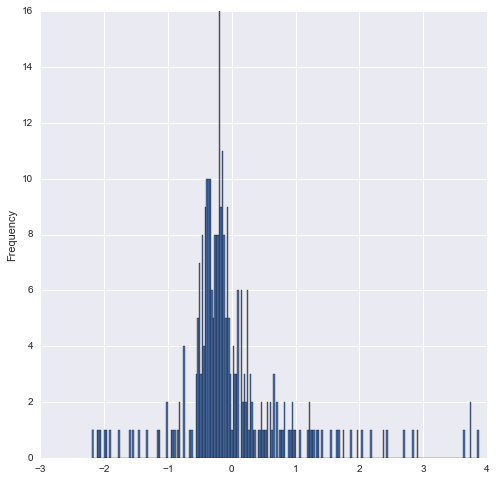

In [1025]:
model.resid.plot(kind = 'hist', bins = 250, figsize = (8, 8))

plt.show()

## Normality Assumption - q-q Plot against a normal distribution

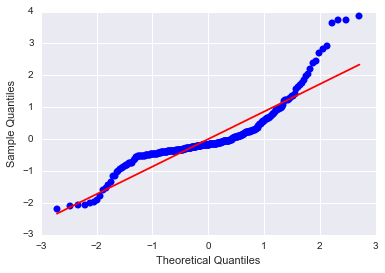

In [983]:
# Plotting qqolots to check normality assumption - Plot of the quantiles of the first dataset (vertically) against the quantiles of the second’s (horizontally)
figure = sm.qqplot(model.resid, line = 's')

# checking modeling assumptions

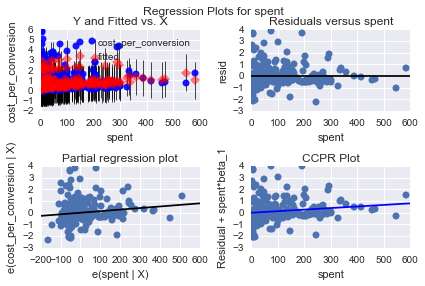

In [984]:
# to check modeling assumptions with respect to a single regressor
figure = sm.graphics.plot_regress_exog(model, 'spent')

### Effect of outliers on regression modeling - SalePrice as a function of Size

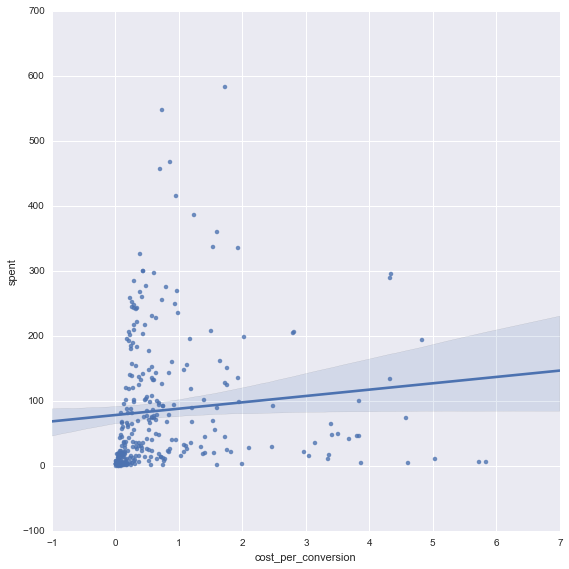

In [1027]:
sns.lmplot('cost_per_conversion', 'spent', training_df, size = 8)

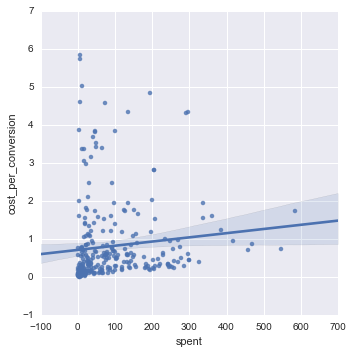

In [1028]:
sns.lmplot('spent', 'cost_per_conversion', training_df)

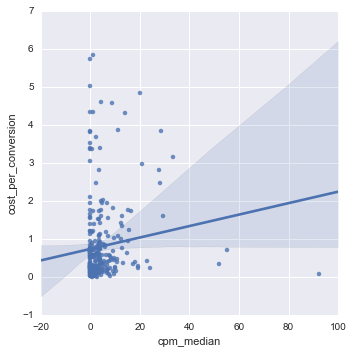

In [1029]:
sns.lmplot('cpm_median', 'cost_per_conversion', training_df)

## Better Model ? 

** How do I decide which features to include in a linear model? Here's one idea:**
- Try different models, and only keep predictors in the model if they have small p-values.
Check whether the R-squared value goes up when you add new predictors.
What are the drawbacks to this approach?
Linear models rely upon a lot of assumptions (such as the features being independent), and if those assumptions are violated (which they usually are), R-squared and p-values are less reliable.
Using a p-value cutoff of 0.05 means that if you add 100 predictors to a model that are pure noise, 5 of them (on average) will still be counted as significant.
R-squared is susceptible to overfitting, and thus there is no guarantee that a model with a high R-squared value will generalize.

In [985]:
model2 = smf.ols(formula = 'cost_per_conversion ~ spent + cpm_median + Objective_EVENT_RESPONSES  + Objective_MOBILE_APP_INSTALLS + Objective_WEBSITE_CONVERSIONS', data = training_df).fit()

model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     cost_per_conversion   R-squared:                       0.336
Model:                             OLS   Adj. R-squared:                  0.327
Method:                  Least Squares   F-statistic:                     36.88
Date:                 Thu, 21 Apr 2016   Prob (F-statistic):           5.89e-25
Time:                         23:46:59   Log-Likelihood:                -383.28
No. Observations:                  297   AIC:                             776.6
Df Residuals:                      292   BIC:                             795.0
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Intercept                         0.3698      0.075      4.899      0.000         0.221     0.518
spent                             0.0015      0.001      2.864      0.004         0.000     0.002
cpm_median                        0.0192      0.006      3.180      0.002         0.007     0.031
Objective_EVENT_RESPONSES      1.082e-15   1.71e-16      6.321      0.000      7.45e-16  1.42e-15
Objective_MOBILE_APP_INSTALLS     2.4520      0.340      7.210      0.000         1.783     3.121
Objective_WEBSITE_CONVERSIONS     1.7076      0.177      9.624      0.000         1.358     2.057
==============================================================================
Omnibus:                      115.772   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              480.178
Skew:                           1.619   Prob(JB):                    5.38e-105
Kurtosis:                       8.321   Cond. No.                     6.90e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.11e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [986]:
model2.rsquared

0.33563514137854

R-squared will always increase as you add more features to the model, even if they are unrelated to the response. Thus, selecting the model with the highest R-squared is not a reliable approach for choosing the best linear model.
So is there a better approach to feature selection? Cross-validation. It provides a more reliable estimate of out-of-sample error, and thus is a better way to choose which of your models will best generalize to out-of-sample data. 

## Plotting the Least Squares Line

In [987]:
model3 = smf.ols(formula = 'cost_per_conversion ~ spent', data = training_df).fit()

model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     cost_per_conversion   R-squared:                       0.011
Model:                             OLS   Adj. R-squared:                  0.007
Method:                  Least Squares   F-statistic:                     3.211
Date:                 Thu, 21 Apr 2016   Prob (F-statistic):             0.0742
Time:                         23:47:04   Log-Likelihood:                -442.40
No. Observations:                  297   AIC:                             888.8
Df Residuals:                      295   BIC:                             896.2
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.7073      0.082      8.642      0.000         0.546     0.868
spent          0.0011      0.001      1.792      0.074        -0.000     0.002
==============================================================================
Omnibus:                      166.659   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              762.407
Skew:                           2.476   Prob(JB):                    2.79e-166
Kurtosis:                       9.090   Cond. No.                         174.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [988]:
# create a DataFrame with the minimum and maximum values of TV
X_new = pd.DataFrame({'spent': [data.spent.min(), data.spent.max()]})
X_new.head()

,spent
0,0.03
1,624.86


In [989]:
# make predictions for those x values and store them
preds = model3.predict(X_new)
preds

array([ 0.70735851,  1.39622046])

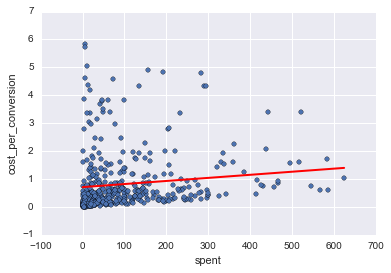

In [990]:
# first, plot the observed data
data.plot(kind='scatter', x='spent', y='cost_per_conversion')

# then, plot the least squares line
plt.plot(X_new, preds, c='red', linewidth=2)

In [991]:
X = data[data.columns.values]
X.drop('cost_per_conversion', axis = 1, inplace = True)
X.drop('cost_per_click', axis = 1, inplace = True)
X.drop('conversions', axis = 1, inplace = True)
X.drop('clicks', axis = 1, inplace = True)
X.drop('impressions', axis = 1, inplace = True)

y = data.cost_per_conversion

In [992]:
len(X)

495

In [993]:
X.head()

,campaign_id,reach,cpa_min,cpa_max,cpa_median,cpc_min,cpc_max,cpc_median,cpm_min,cpm_max,...,maxBid,Bid_Type_CONVERSION_OPTIMIZE,Bid_Type_OPTIMIZE,Bid_Type_ROTATE,Bid_Type_ROTATE_INDEFINITELY,Bid_Type_automated,Bid_Type_cpc,Bid_Type_ocpm,maxBid_cpc,maxBid_ocpm
1,6023634601941,198000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,1,0,0,0,0
2,6024469111228,74000,1.12,3.11,2.14,0.15,0.37,0.27,5.16,14.43,...,0,0,0,0,0,1,0,0,0,0
3,6025116981459,1300000,1.15,3.93,2.50,1.16,3.38,2.23,5.13,22.03,...,0,0,0,0,0,1,0,0,0,0
4,6025234083437,93000,0.18,0.37,0.29,0.13,0.26,0.20,1.16,3.91,...,0,0,0,0,0,1,0,0,0,0
5,6025631750902,3050000,0.68,1.44,1.10,0.37,0.83,0.63,1.11,8.23,...,0,0,0,0,0,1,0,0,0,0


In [994]:
X.drop('bidStrategy', axis = 1, inplace = True)
X.drop('objective', axis = 1, inplace = True)
X.drop('campaign_group_id', axis = 1, inplace = True)
X.drop('reach', axis = 1, inplace = True)

In [995]:
#X.cost_per_click = X.cost_per_click.round(decimals=2)
#X.cost_per_conversion = X.cost_per_conversion.round(decimals=2)

In [996]:
X.columns

Index([u'campaign_id', u'cpa_min', u'cpa_max', u'cpa_median', u'cpc_min',
       u'cpc_max', u'cpc_median', u'cpm_min', u'cpm_max', u'cpm_median',
       u'spent', u'date', u'Objective_EVENT_RESPONSES',
       u'Objective_LEAD_GENERATION', u'Objective_LOCAL_AWARENESS',
       u'Objective_MOBILE_APP_ENGAGEMENT', u'Objective_MOBILE_APP_INSTALLS',
       u'Objective_NONE', u'Objective_PAGE_LIKES',
       u'Objective_POST_ENGAGEMENT', u'Objective_VIDEO_VIEWS',
       u'Objective_WEBSITE_CLICKS', u'Objective_WEBSITE_CONVERSIONS',
       u'maxBid', u'Bid_Type_CONVERSION_OPTIMIZE', u'Bid_Type_OPTIMIZE',
       u'Bid_Type_ROTATE', u'Bid_Type_ROTATE_INDEFINITELY',
       u'Bid_Type_automated', u'Bid_Type_cpc', u'Bid_Type_ocpm', u'maxBid_cpc',
       u'maxBid_ocpm'],
      dtype='object')

Now we have to split the datasets into training and validation. The training data will be used to generate the trees that will constitute the final averaged model.

In [1019]:
train_X, test_X, train_y, test_y = cross_validation.train_test_split(X, y, test_size = 0.4)

### Linear Regression - scikit-learn

We use cross validation to compare between models and choose the model with the best cross validation value. Once we discover that we need to create a final model and then predict using it

In [1020]:
train_df_X = training_df[ ['spent', 'cpa_median','cpc_median','cpm_median',
       'date', 'Objective_EVENT_RESPONSES',
       'Objective_LEAD_GENERATION', 'Objective_LOCAL_AWARENESS',
       'Objective_MOBILE_APP_ENGAGEMENT', 'Objective_MOBILE_APP_INSTALLS',
       'Objective_NONE', 'Objective_PAGE_LIKES',
       'Objective_POST_ENGAGEMENT', 'Objective_VIDEO_VIEWS',
       'Objective_WEBSITE_CONVERSIONS',
       'Bid_Type_CONVERSION_OPTIMIZE', 'Bid_Type_OPTIMIZE',
       'Bid_Type_ROTATE', 'Bid_Type_ROTATE_INDEFINITELY',
       'Bid_Type_automated', 'Bid_Type_cpc', 'maxBid_cpc'] ]
train_df_y = training_df['cost_per_conversion']

model = linear_model.LinearRegression()
cross_validation.cross_val_score(model, train_df_X, train_df_y, cv = 10).mean()

0.099082636581307185

In [999]:
train_df_X = training_df[ ['spent', 'Objective_WEBSITE_CONVERSIONS', 'Objective_WEBSITE_CLICKS'] ]
train_df_y = training_df['cost_per_conversion']

model = linear_model.LinearRegression()
cross_validation.cross_val_score(model, train_df_X, train_df_y, cv = 10).mean()

0.05505590329522915

In [1000]:
train_df_X = training_df[ ['spent'] ]
train_df_y = training_df['cost_per_conversion']

model = linear_model.LinearRegression()
cross_validation.cross_val_score(model, train_df_X, train_df_y, cv = 10).mean()

-0.055255281758840237

In [1001]:
train_df_X = training_df[ ['spent','Objective_PAGE_LIKES','Objective_MOBILE_APP_INSTALLS','Objective_WEBSITE_CONVERSIONS']]
train_df_y = training_df['cost_per_conversion']

model = linear_model.LinearRegression()
cross_validation.cross_val_score(model, train_df_X, train_df_y, cv = 10).mean()

0.14710736752065892

In [1002]:
train_df_X = training_df[ ['spent','cpm_median', 'Objective_EVENT_RESPONSES','Objective_LEAD_GENERATION', 'Objective_MOBILE_APP_ENGAGEMENT', 'Objective_MOBILE_APP_INSTALLS', 'Objective_WEBSITE_CONVERSIONS']]
train_df_y = training_df['cost_per_conversion']

model = linear_model.LinearRegression()
cross_validation.cross_val_score(model, train_df_X, train_df_y, cv = 10).mean()

0.17196953343915306

In [1003]:
train_df_X = training_df[ ['spent','cpm_median','Objective_EVENT_RESPONSES','Objective_LEAD_GENERATION', 'Objective_MOBILE_APP_ENGAGEMENT', 'Objective_MOBILE_APP_INSTALLS','Objective_WEBSITE_CLICKS', 'Objective_WEBSITE_CONVERSIONS']]
train_df_y = training_df['cost_per_conversion']

model = linear_model.LinearRegression()
cross_validation.cross_val_score(model, train_df_X, train_df_y, cv = 10).mean()

0.17142537550561193

# Regression Decision Trees

In [1004]:
#X.cost_per_click = X.cost_per_click.round(decimals=2)
#X.cost_per_conversion = X.cost_per_conversion.round(decimals=2)

In [1005]:
train_X, test_X, train_y, test_y = cross_validation.train_test_split(X, y, test_size = 0.4)

In [1006]:
model = tree.DecisionTreeRegressor()
model.fit(train_X, train_y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

### Calculating MSE (Mean squared error regression loss)

In [1007]:
train_y_hat = model.predict(train_X)
print np.sqrt(metrics.mean_squared_error(train_y, train_y_hat))

test_y_hat = model.predict(test_X)
print np.sqrt(metrics.mean_squared_error(test_y, test_y_hat))

3.26260236386e-05
1.06959346685


In [1008]:
model = tree.DecisionTreeRegressor(max_depth = 4)
model.fit(train_X, train_y)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

### Calculate Features Importance

In [1009]:
sorted(zip(model.feature_importances_, X.columns.values), reverse = True)

[(0.3464984126088082, 'Objective_MOBILE_APP_INSTALLS'),
 (0.21648661496702232, 'Objective_WEBSITE_CONVERSIONS'),
 (0.14450823733512688, 'cpc_max'),
 (0.11076573929317068, 'spent'),
 (0.069218809955551547, 'campaign_id'),
 (0.056597005179035653, 'Objective_PAGE_LIKES'),
 (0.031523213252586162, 'cpa_min'),
 (0.023316771090567887, 'date'),
 (0.00082743779843137753, 'cpm_min'),
 (0.0002577585196992478, 'cpc_min'),
 (0.0, 'maxBid_ocpm'),
 (0.0, 'maxBid_cpc'),
 (0.0, 'maxBid'),
 (0.0, 'cpm_median'),
 (0.0, 'cpm_max'),
 (0.0, 'cpc_median'),
 (0.0, 'cpa_median'),
 (0.0, 'cpa_max'),
 (0.0, 'Objective_WEBSITE_CLICKS'),
 (0.0, 'Objective_VIDEO_VIEWS'),
 (0.0, 'Objective_POST_ENGAGEMENT'),
 (0.0, 'Objective_NONE'),
 (0.0, 'Objective_MOBILE_APP_ENGAGEMENT'),
 (0.0, 'Objective_LOCAL_AWARENESS'),
 (0.0, 'Objective_LEAD_GENERATION'),
 (0.0, 'Objective_EVENT_RESPONSES'),
 (0.0, 'Bid_Type_ocpm'),
 (0.0, 'Bid_Type_cpc'),
 (0.0, 'Bid_Type_automated'),
 (0.0, 'Bid_Type_ROTATE_INDEFINITELY'),
 (0.0, 'Bid_Ty

## Random Forest Classifier

In [1010]:
model = ensemble.RandomForestRegressor(n_estimators = 1000, max_features = 4, min_samples_leaf = 5, oob_score = True)
model.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [1011]:
model.oob_score_

0.27342168232829955

The out-of-bag (OOB) error is the average error for each z_i calculated using predictions from the trees that do not contain z_i in their respective bootstrap sample.

In [1012]:
cross_validation.cross_val_score(model, train_X, train_y, cv = 10).mean()

0.19785216217767729

# Bosted Trees

We then fit a Gradient Tree Boosting model to the data using the scikit-learn package. We will use 500 trees with each tree having a depth of 6 levels. we will also use the Huber loss function.

In [1013]:
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators': 500, 'max_depth': 6, 'loss': 'huber','alpha':0.95}

clf = GradientBoostingRegressor(**params).fit(train_X, train_y)

the Mean Squared Error wasn’t much informative and used instead the R2 coefficient of determination. This measure is a number indicating how well a variable is able to predict the other. Values close to 0 means poor prediction and values close to 1 means perfect prediction. within our model we got 0.89 so it’s a good out of the box technique.

In [1014]:
mse = mean_squared_error(test_y, clf.predict(test_X))
r2 = r2_score(test_y, clf.predict(test_X))
 
print("MSE: %.4f" % mse)
print("R2: %.4f" % r2)

MSE: 0.8087
R2: 0.3727


Let’s plot how does the training and testing error behave

/Users/Edie/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function staged_decision_function is deprecated;  and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


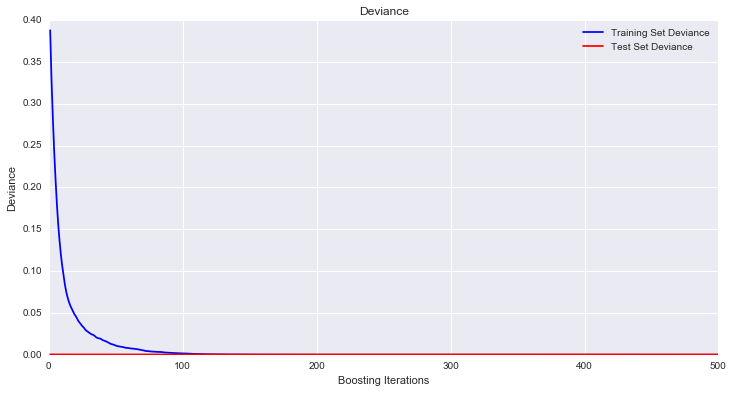

In [1015]:
import matplotlib.pyplot as plt
 
# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
 
for i, y_pred in enumerate(clf.staged_decision_function(test_X)):
    test_score[i] = clf.loss_(test_y, y_pred)
 
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
                label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
                label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

As you can see in the previous graph, although the train error keeps going down as we add more trees to our model, the test error remains more or less constant and doesn’t incur in overfitting. This is mainly due to the shrinkage parameter and one of the good features of this algorithm.

Although base trees are easily interpretable when you are adding several of those trees interpretation is more difficult. You usually rely on some measures of the predictive power of each feature. Let’s plot feature importance in predicting the House Value.

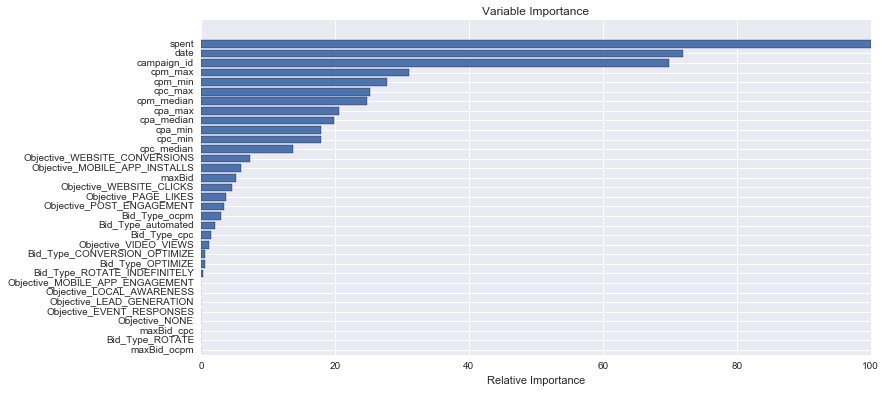

In [1016]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [1017]:
train_X.columns

Index([u'campaign_id', u'cpa_min', u'cpa_max', u'cpa_median', u'cpc_min',
       u'cpc_max', u'cpc_median', u'cpm_min', u'cpm_max', u'cpm_median',
       u'spent', u'date', u'Objective_EVENT_RESPONSES',
       u'Objective_LEAD_GENERATION', u'Objective_LOCAL_AWARENESS',
       u'Objective_MOBILE_APP_ENGAGEMENT', u'Objective_MOBILE_APP_INSTALLS',
       u'Objective_NONE', u'Objective_PAGE_LIKES',
       u'Objective_POST_ENGAGEMENT', u'Objective_VIDEO_VIEWS',
       u'Objective_WEBSITE_CLICKS', u'Objective_WEBSITE_CONVERSIONS',
       u'maxBid', u'Bid_Type_CONVERSION_OPTIMIZE', u'Bid_Type_OPTIMIZE',
       u'Bid_Type_ROTATE', u'Bid_Type_ROTATE_INDEFINITELY',
       u'Bid_Type_automated', u'Bid_Type_cpc', u'Bid_Type_ocpm', u'maxBid_cpc',
       u'maxBid_ocpm'],
      dtype='object')

Once variable importance has been identified we could try to investigate how those variables interact between them. For instance, we can plot the dependence of the target variable with another variable has been averaged over the values of the other variables not being taken into consideration. Some variables present a clear monotonic dependence with the target value, while others seem not very related to the target variable even when they ranked high in the previous plot. This could be signaling an interaction between variables that could be further studied.

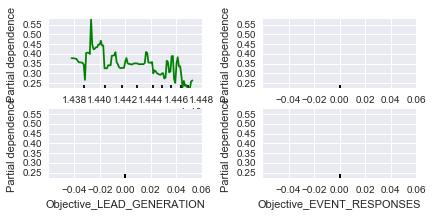

In [1018]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
 
fig, axs = plot_partial_dependence(clf, train_X,
                                   features=[11,17,13,12],
                                   feature_names=train_X.columns,
                                   n_cols=2)
 
fig.show((16,16))
#clicks, cost_per_conversion, impressions, spent